# Name Generator

Our goal this time is to build on our neural network and make it able to predict names. We replace the use of micrograd with built in features in pytorch. We start however by 'hard-coding' a predictive model with no neural network learning.
We follow this video here:

> https://www.youtube.com/watch?v=PaCmpygFfXo

In order to start, we import a text file of 32033 names. The file can be found here
>https://github.com/karpathy/makemore/blob/master/names.txt

We want to make sure each name is its own string seperated in a list so that we may be able to iterate between names and between characters in a name

In [819]:
names = open('names.txt','r').read().splitlines()

Here are some properties of our names we may want to keep in mind as we later improve our model.

In [820]:
min(len(n) for n in names)

2

In [821]:
max(len(n) for n in names)

15

Our first goal is to train our model on what are called bigrams. They are two letter increments of a name. Eventually our model will look at the current letter and predict the next letter based on frequencies of bigrams starting with the current letter. This should give us better predicitions than selecting with an equal probability distribution. To do this, we get a counter of different bigrams.

In [822]:
freq_count = {}
for n in names:
    chs = ['.'] + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        freq_count[bigram] = freq_count.get(bigram, 0) + 1

We observe the most common occurances in names. Note that '.' is our marker for the beginning of the word and the end of the word

In [823]:
sorted(freq_count.items(), key = lambda kv: -kv[1])

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

Now, even though we will not do any gradient descent learning, we will still use pytorch. We do this because the pytorch matrix is an efficient way to store data that allows us to do many processes in parallel rather than sequence. The following four cells are importing frequencies into a 27x27 matrix

In [824]:
import torch

In [825]:
N = torch.zeros((27,27), dtype = torch.int32)

In [826]:
chars = sorted(list(set(''.join(names)))) #creates a list of all letters in order (pretty sure there is a built in function for this but w.e)
stoi = {s:i+1 for i,s in enumerate(chars)} #creates a function that takes a letter and gives an integer
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} #creates a function that takes an integer and gives a letter

In [827]:
for n in names:
    chs = ['.'] + list(n) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        N[i,j]+=1

If we try print N currently, we get a mess that is hard and annoying to read as seen below. 

In [828]:
N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

Thus our goal is to visualize N in a way that is easily legible. To do this, we use matplot and print inline. If you need/want to learn more about this package please read the documentation here
>https://matplotlib.org/stable/

Our goal in visualization is to print the bigram and have the count directly below it. We also color sort so that it is easy at a glance to tell what is more common and what is less common.

In [829]:
import matplotlib.pyplot as plt
%matplotlib inline

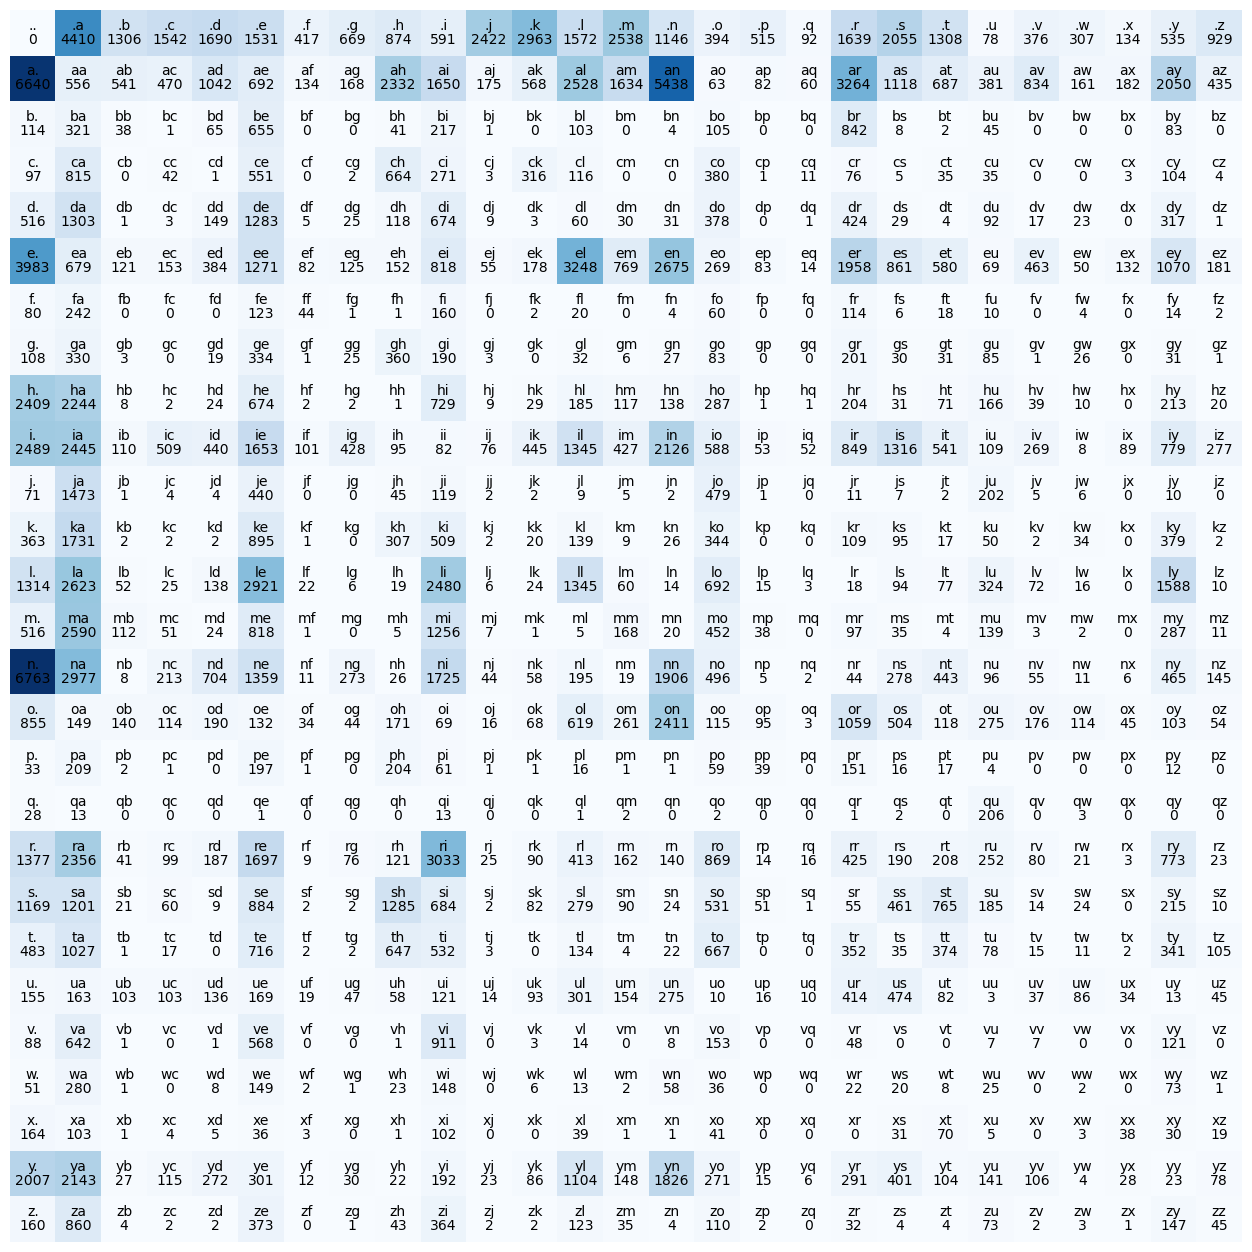

In [830]:
plt.figure(figsize = (16,16))
plt.imshow(N, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, N[i,j].item(), ha = "center", va = "top", color = "black")
plt.axis('off');

In our model, we assume that we know the current letter. Now, note that all the bigrams starting with a given letter makes up a singular row of the above matrix. Thus we want to show two different ways we can pull a row. We will only use the later method going forward.

In [831]:
N[0, :]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [832]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

We now want to give a quick run down on multinomial selection. First off, a multinomial distribution is a discrete probability space with finite number of outcomes each with a fixed probability such that all probabilities add up to 1. To read more on multinomial distributions, please reference the following if needed:
>https://en.wikipedia.org/wiki/Multinomial_distribution

Our space can be viewed as 27 different multinomial probability spaces - 1 space for each starting character. We want to illustrate how selecion in such a space works via a computer. We start by generating a random 3x1 matrix and normalizing it so that it becomes a probability space

In [833]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3,generator = g)
p = p /p.sum()

In [834]:
print(p)
print(p.sum())

tensor([0.6064, 0.3033, 0.0903])
tensor(1.)


We see that the probability of space 0 is .6, for space 1 it is .3 and for space 3 it is .09. We want to use these probabilities to randomly select a space. We are going to make the selection 100 times. We would expect about 60 0s, 30 1s and 9 2s. One can go through and count the outcomes if they wish, however, there is a wide variance on some of these. For instance, the variance on the 0th spot can be calculated as such
> $ var(X_0) = 100(0.6)(1-.6) = 24$

Thus, it would most likely not be wise to place too much value in the exact number. So long at it is reasonably close

In [835]:
torch.multinomial(p, num_samples = 100, replacement = True, generator = g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

As mentioned above, we can view our matrix as 27 different probability spaces. We can normalize each row in order to turn them into a probability space. We give an example by normalizing the 0th row. This will always be our starting row due to constructing our bigrams so that '.' is the first letter of every name

In [836]:
p = N[0].float()
p = p / p.sum()
print(p)
print(p.sum())

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])
tensor(1.)


Similarly to above, we can use a multinomial selection in order to choose an outcome. The out come will be an integer. It is thus important to translate our integers to strings via our itos function/dictionary defined in cell 19 (assuming no recompiling has occured).

In [837]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
itos[ix]

'c'

While it is possible to normalize every row each time it is called and get our probabilities that way, that is extremely slow since the computer does not remember what the normalization is if it ever needs to recalcuate for the same row. Caching is often used for such a problem. However, we wish to normalize the entire matrix all at once and store said normalization. While you can do this with a loop going row by row, this will also be slower than other options. Instead we want to use the broadcasting feature of pytorch tensors. This is the entire reason to make use of pytorch in this begining model. We highly recommend the reader to read more about broadcasting in tensors at the given link:
>https://pytorch.org/docs/stable/notes/broadcasting.html

If the reader wants to use pytorch more regularly, we also recommend they watch the tutorials here:
>https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html

Note, in our normalizing each row, we add one to every count so that no outcome has probability 0. The reason for this has to do with the fact that our loss function will involve using logrithms and we want to be able to measure how unlikely any given name is - even if it is complete giberish inputted by the user. The next two cells are creating our probability spaces and displaying them as a matrix up to 3 decimal places

In [838]:
P = (N+1).float()
P /= P.sum(1, keepdim = True)

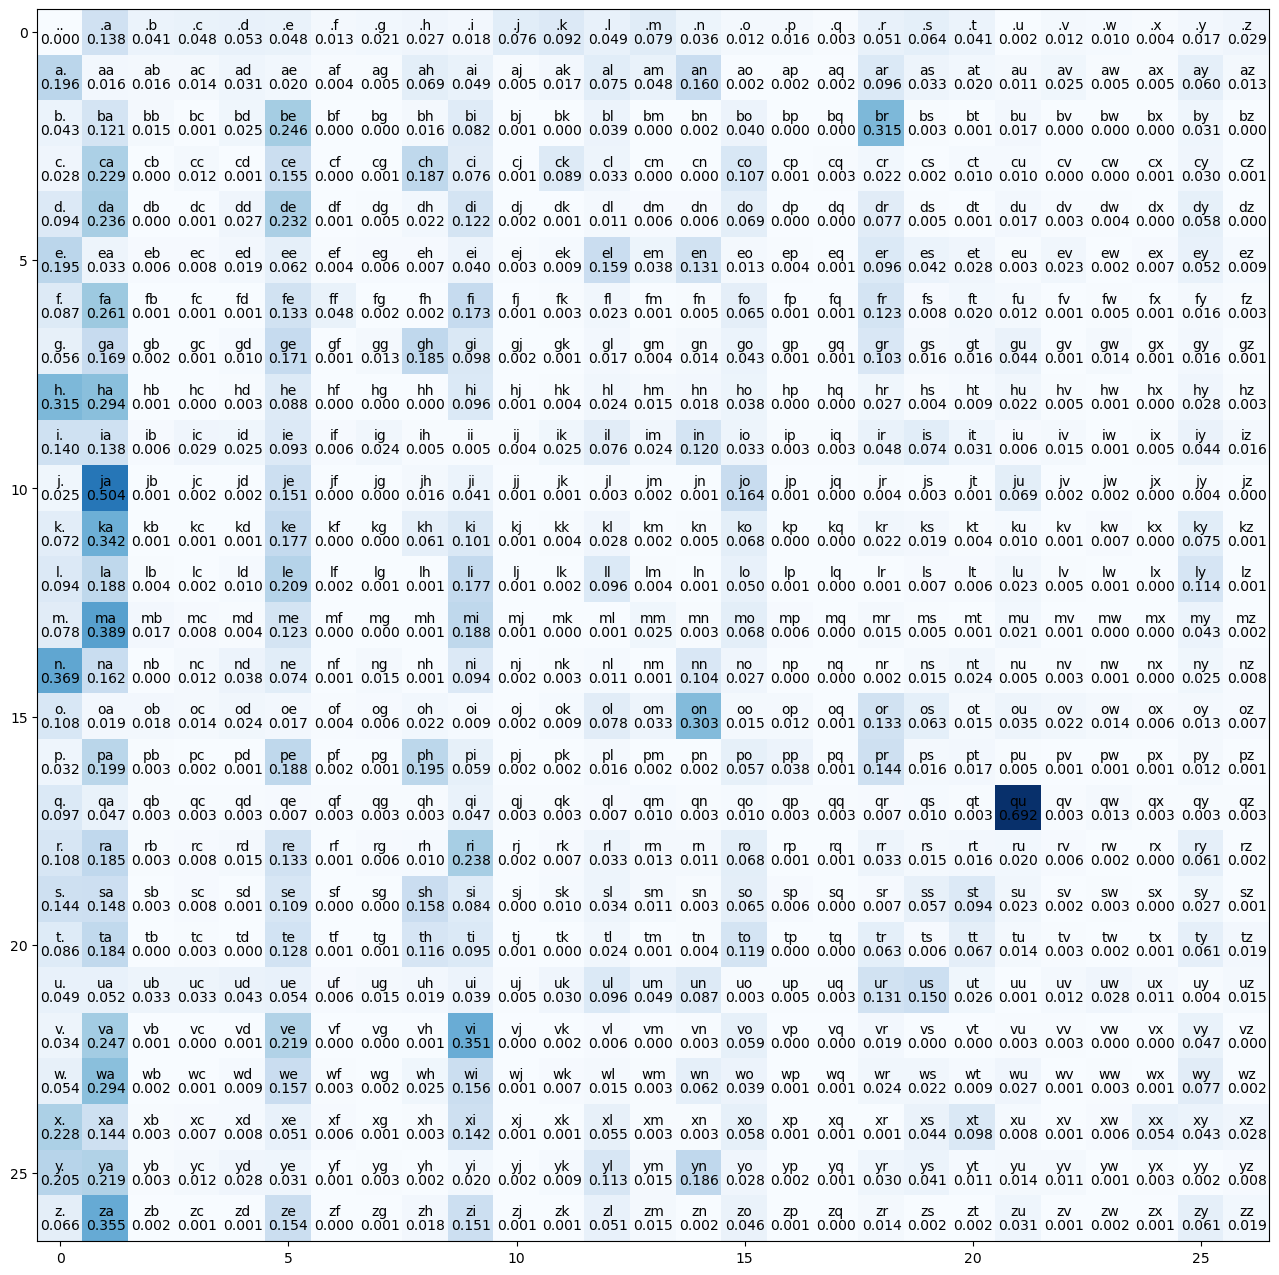

In [839]:
plt.figure(figsize = (16,16))
plt.imshow(P, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %P[i,j].item(), ha = "center", va = "top", color = "black")

For a closer look at each row, we would recommend just printing a single row at a time. The above matrix is not the most accurate representation due to rounding.

We now have a space and method that we can use to predict the next letter of a name. In theory, this means that we will be able to produce name predictions. Thus, let us now try to produce some new names

In [840]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    newname = ''
    ix = 0 #start our name with '.'
    while True:
        ix = torch.multinomial(P[ix], num_samples = 1, replacement = True, generator = g).item() #select the appropriate row, and choose a new letter based on proabilites
        if ix == 0: #if the new letter selected is '.', we finish the name
            break
        newname += itos[ix] #add the new letter to the name we are producing
    print(newname) #print the final name

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


The names above are not the best. There really isnt a name any of us would love to have (most likely). Thus, we want to measure how bad our name production is. We use something called normalized negative loglikelihood in order to achieve this measure. We run this measure first on the entire set of names from our training set.

In [841]:
loglikelihood = 0.00
n =0 
for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        loglikelihood += logprob
        n+=1
        
nll = -loglikelihood
print(f'{nll=}')
print(f'{nll/n}')

nll=tensor(559951.5625)
2.4543561935424805


This is essentially equivalent to a measure of variance. Every training set is going to have some variance in the names it gives - otherwise em would always produce the name emma rather than allowing the possibility of emily.

Now, we want to alter our model so that we may use gradiant descent in order to minimize the loss of the names produced. This will require for us to remake the entire model from scratch. However, the resulting model will be strikingly similar to our original model.

This model will be built in a very similar manner as micrograd - however, we will use pytorch's built in features rather than populate new classes ourself. We show case the logic on the first name of our set, Emma

In [842]:
xs, ys = [], [] #initialize sets of inputs and outputs

for name in names[:1]:
    chs = ['.'] +list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1) #current letter is an input
        ys.append(ix2) #next letter is an output

xs = torch.tensor(xs)
ys = torch.tensor(ys)

Note, we currently store our inputs and outputs as integers. This is not ideal as a neural network has random weights should between 0 and 1. This means that none of our inputs will remain an integer after the linear step. For this specific model, there is no step after the linear step - thus our outputs in an actual random model would not be an integer and thus could not be translated to letter without truncation which is not ideal.

In [843]:
xs

tensor([ 0,  5, 13, 13,  1])

In [844]:
ys

tensor([ 5, 13, 13,  1,  0])

Thus, we have to be clever with our implimentation. We instead want our integer to refer to the row desired of our weight matrix. That is, 5 refers to row 5 of the matrix W that will be defined in a second. There are two ways to implement this. One is to hot_ones the integer, however, this solution only works in two dimensions (thus will not work with anything larger than a bigram). Thus, instead, we slightly deviate from the video and leave the xs as is for the time being.

We now initialize a 27 x 27 matrix that is filled with random numbers at each coordinate. Remember that each coordinate represents a specific bigram. We also visualize the matrix below.

In [845]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g, requires_grad = True)

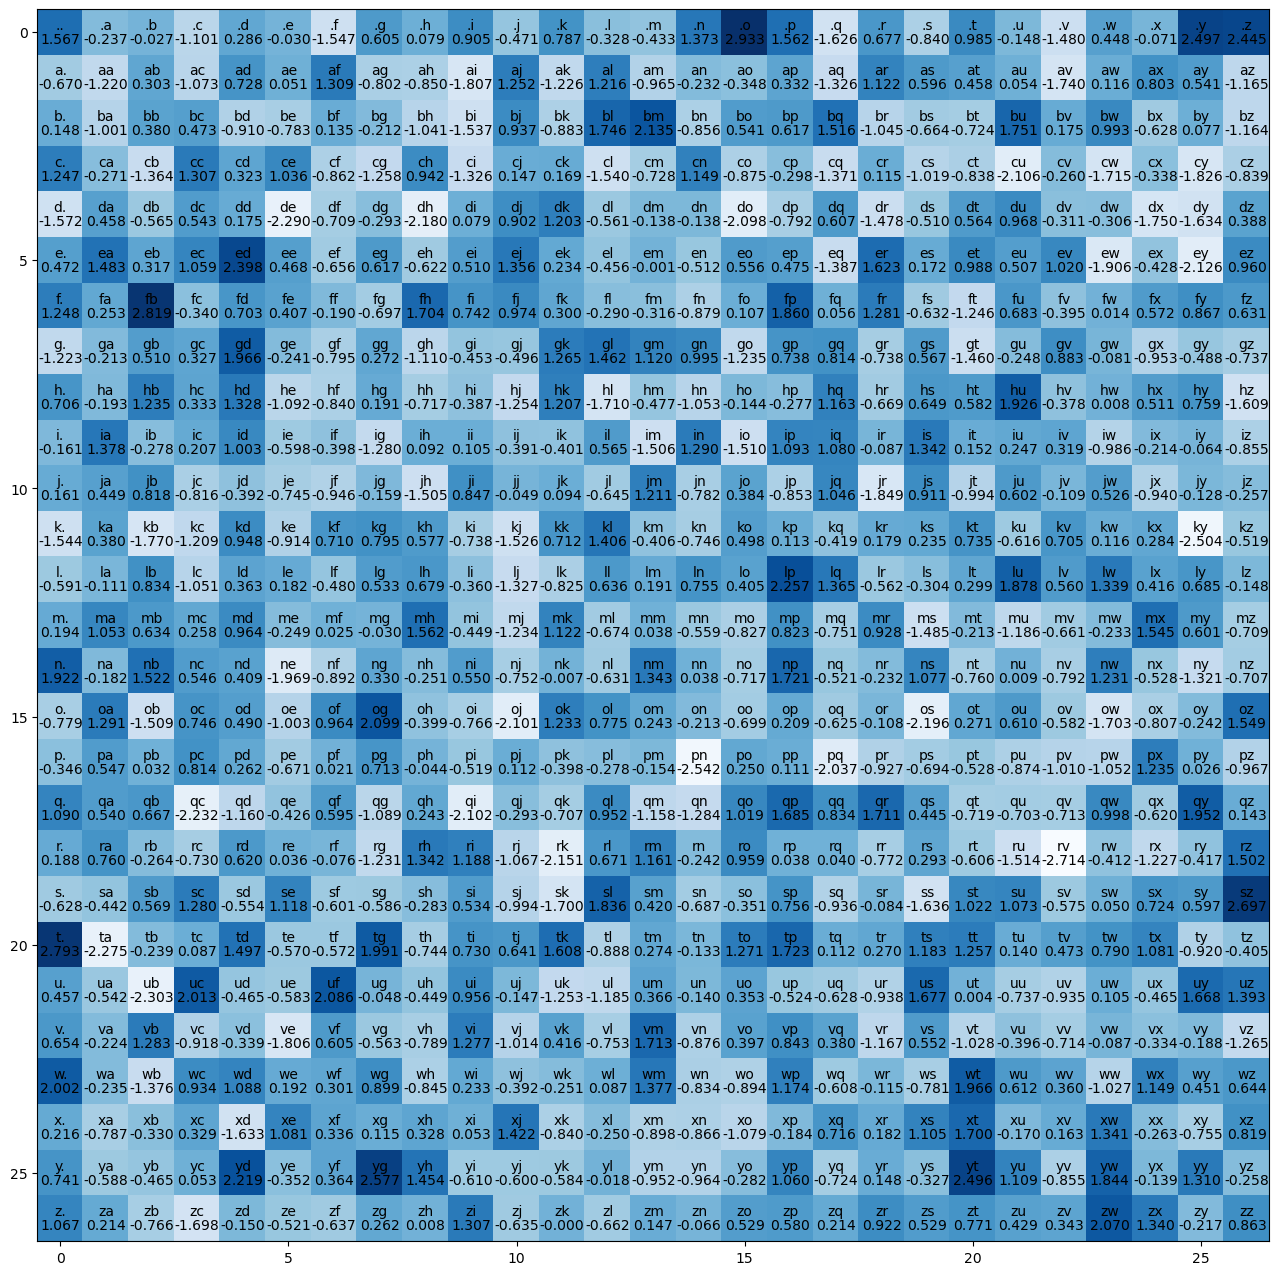

In [846]:
plt.figure(figsize = (16,16))
plt.imshow(W.data, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %W[i,j].item(), ha = "center", va = "top", color = "black")

W is very clearly not a probability matrix as our prior ones have been. Thus we must figure out a way to convert it to a probability. The first thing we want to do is figure out a monotonic function (thus preserving ordering) that turns all numbers positive. The most natural selection is the function $e^x$. Then, once we have all the numbers positive, we can simply normalize each row as we did before. We then calculate the loss as we did before

In [847]:
counts = W.exp()
prob = counts/counts.sum(1, keepdims = True)

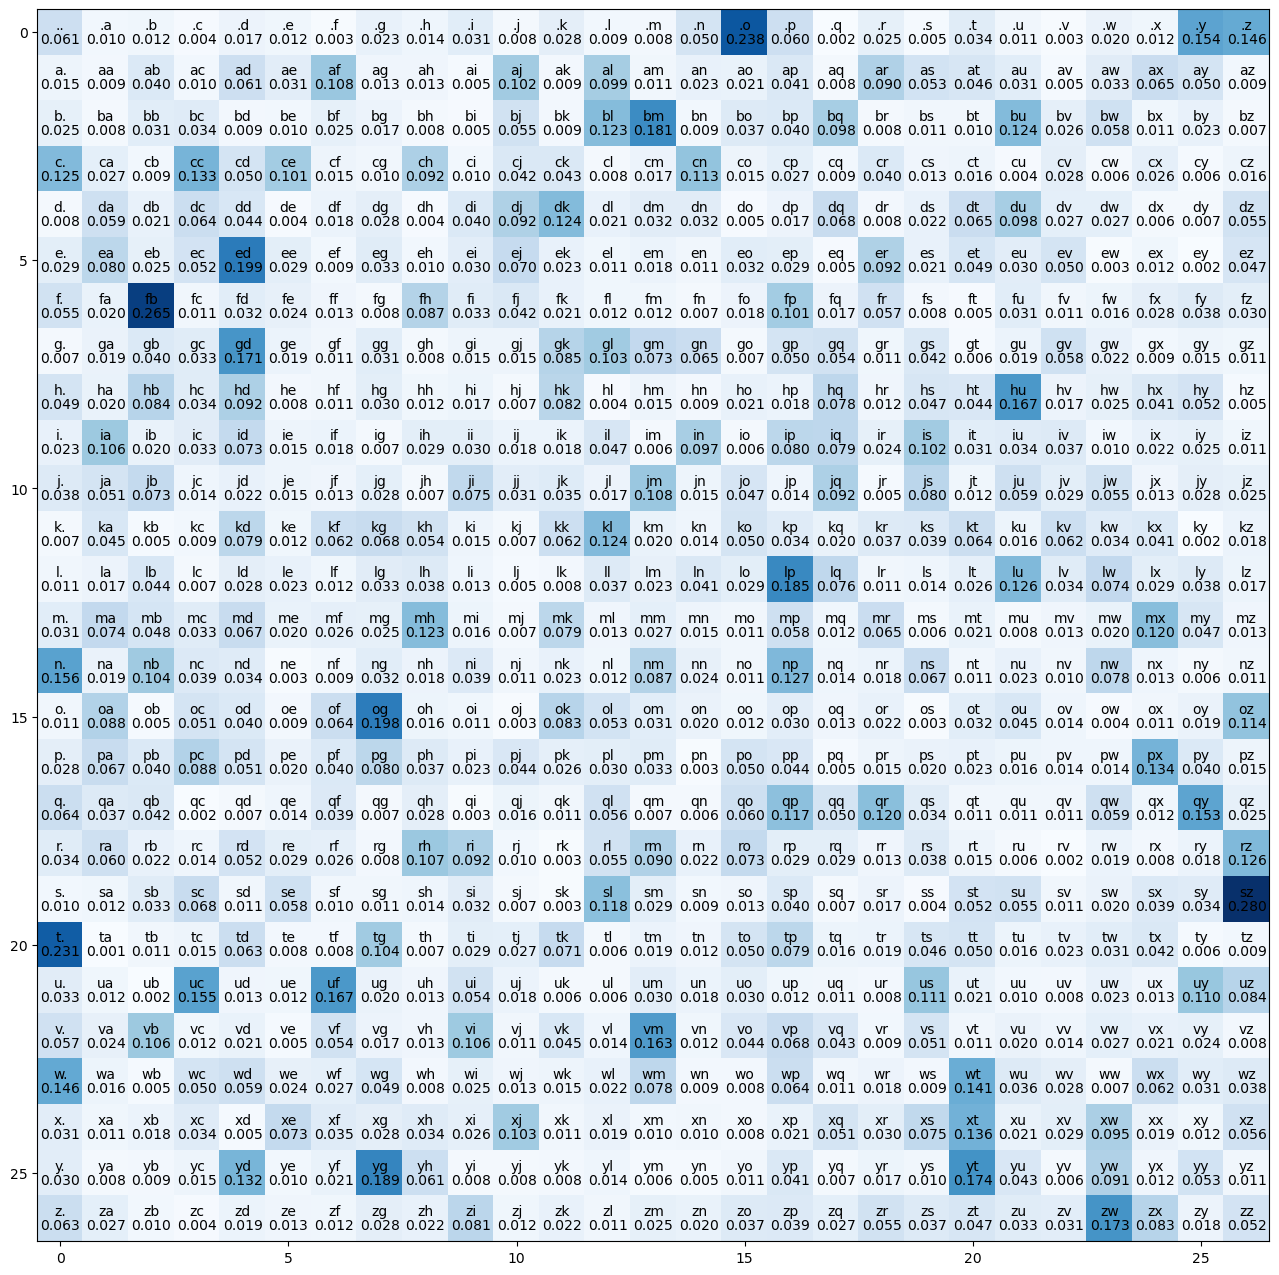

In [848]:
plt.figure(figsize = (16,16))
plt.imshow(prob.data, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %prob[i,j].item(), ha = "center", va = "top", color = "black")

Now, we can caluclate the loss of the given name. We pick out the rows of the relavent letters in our name - which you may recal is Emma. We then take the negative log of these rows enties, sum them up, and then divide by the number of entries. In other words, we take the negative log and then take the mean. Doing this gets us a loss value.

Note, here is where we use our tensor of inputs and outputs. What prob[xs,ys] does is call all cordinates of the form x_i, y_i in the probability matrix at once. The log function takes the log of these and then the mean function adds them all up and divides them by the number of entries. This process is a lot faster than doing this in a loop and is more memory efficient. 

In [849]:
loss = -prob[xs, ys].log().mean()
loss

tensor(3.7693, grad_fn=<NegBackward0>)

Now our goal is to minimize this loss function. In order to do this, we want to keep track of our partial derivatives as we did in micrograd. We will then use gradiant descent in order to minimize our loss function

In [850]:
W.grad = None #initialize derivative values to 0 (uses less memory to set to none first)

In [851]:
loss.backward() #calculate the partial derivatives

We now visualize the gradiant on the random values assigned to each bigram. Do not pay anymind to the coloring of this matrix. Since values are all so small, the coloring is essentially random

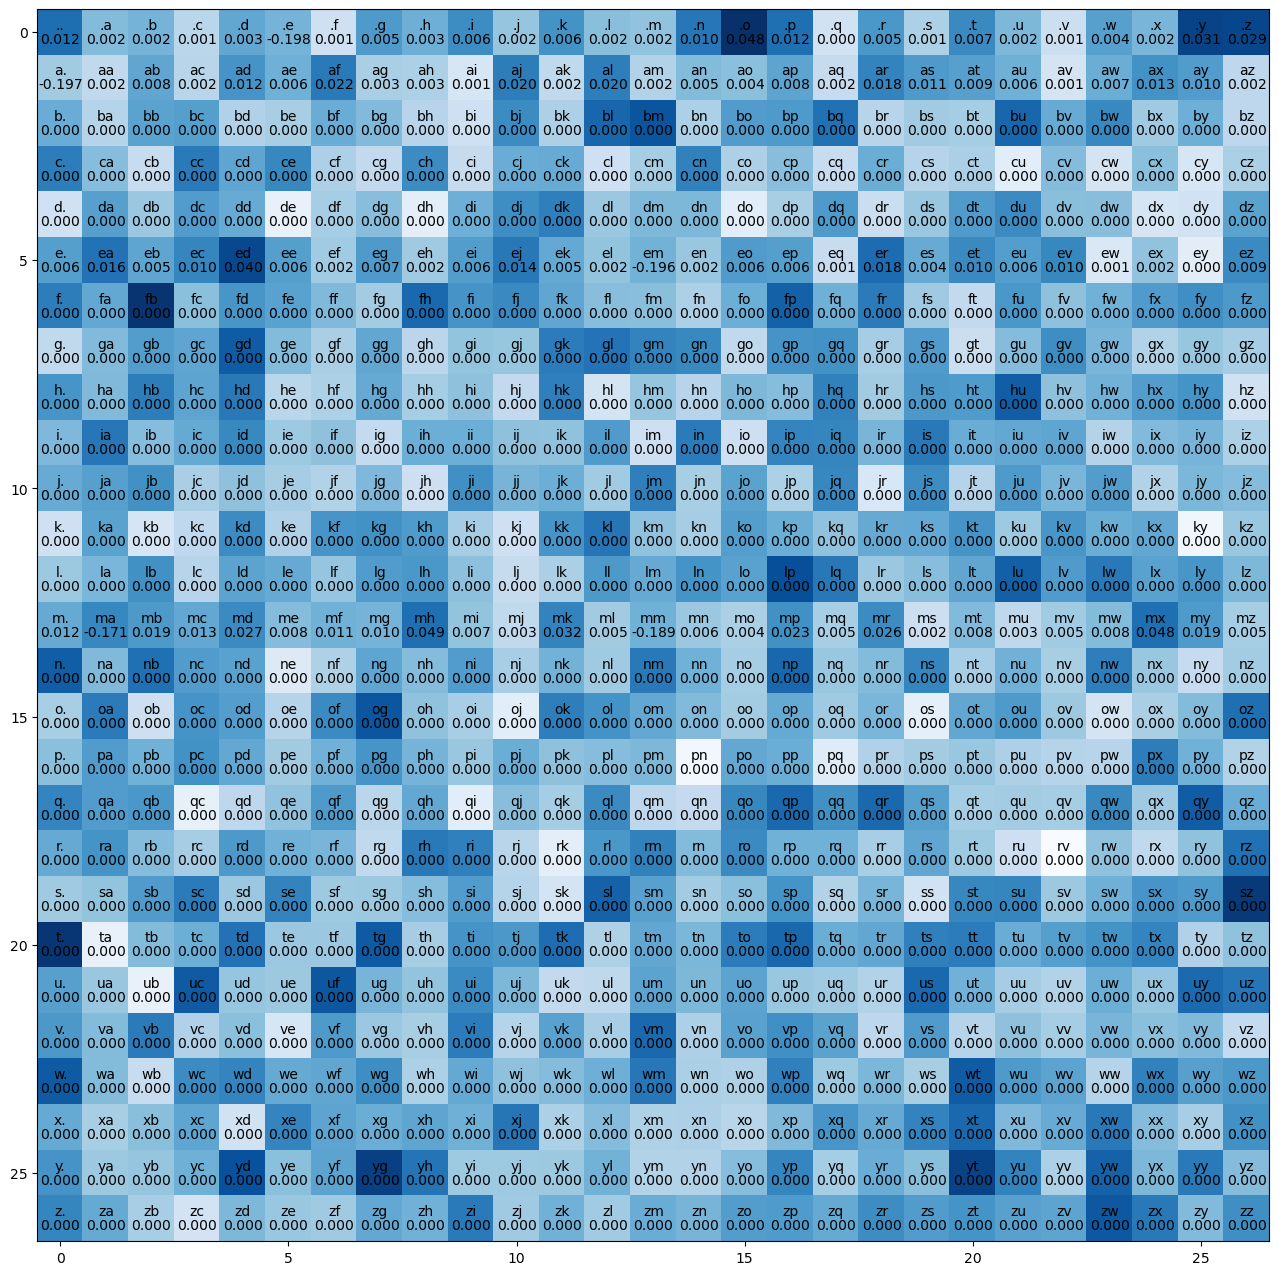

In [852]:
plt.figure(figsize = (16,16))
plt.imshow(W.data, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %W.grad[i,j], ha = "center", va = "top", color = "black")

In order to lower the loss, we need to subtract by a multiple of the gradiant (Remember if a gradiant is positive, it means increasing the data will increase the loss - thus if have positive gradiant want to lower value and vice versa for negative gradiant)

In [853]:
W.data -= 0.1 *W.grad

We now recalculate our loss the same way we did before.

In [854]:
counts = W.exp()
prob = counts/counts.sum(1, keepdims = True)
loss = -prob[xs, ys].log().mean()

In [855]:
loss

tensor(3.7492, grad_fn=<NegBackward0>)

We visualize our new probabilities.

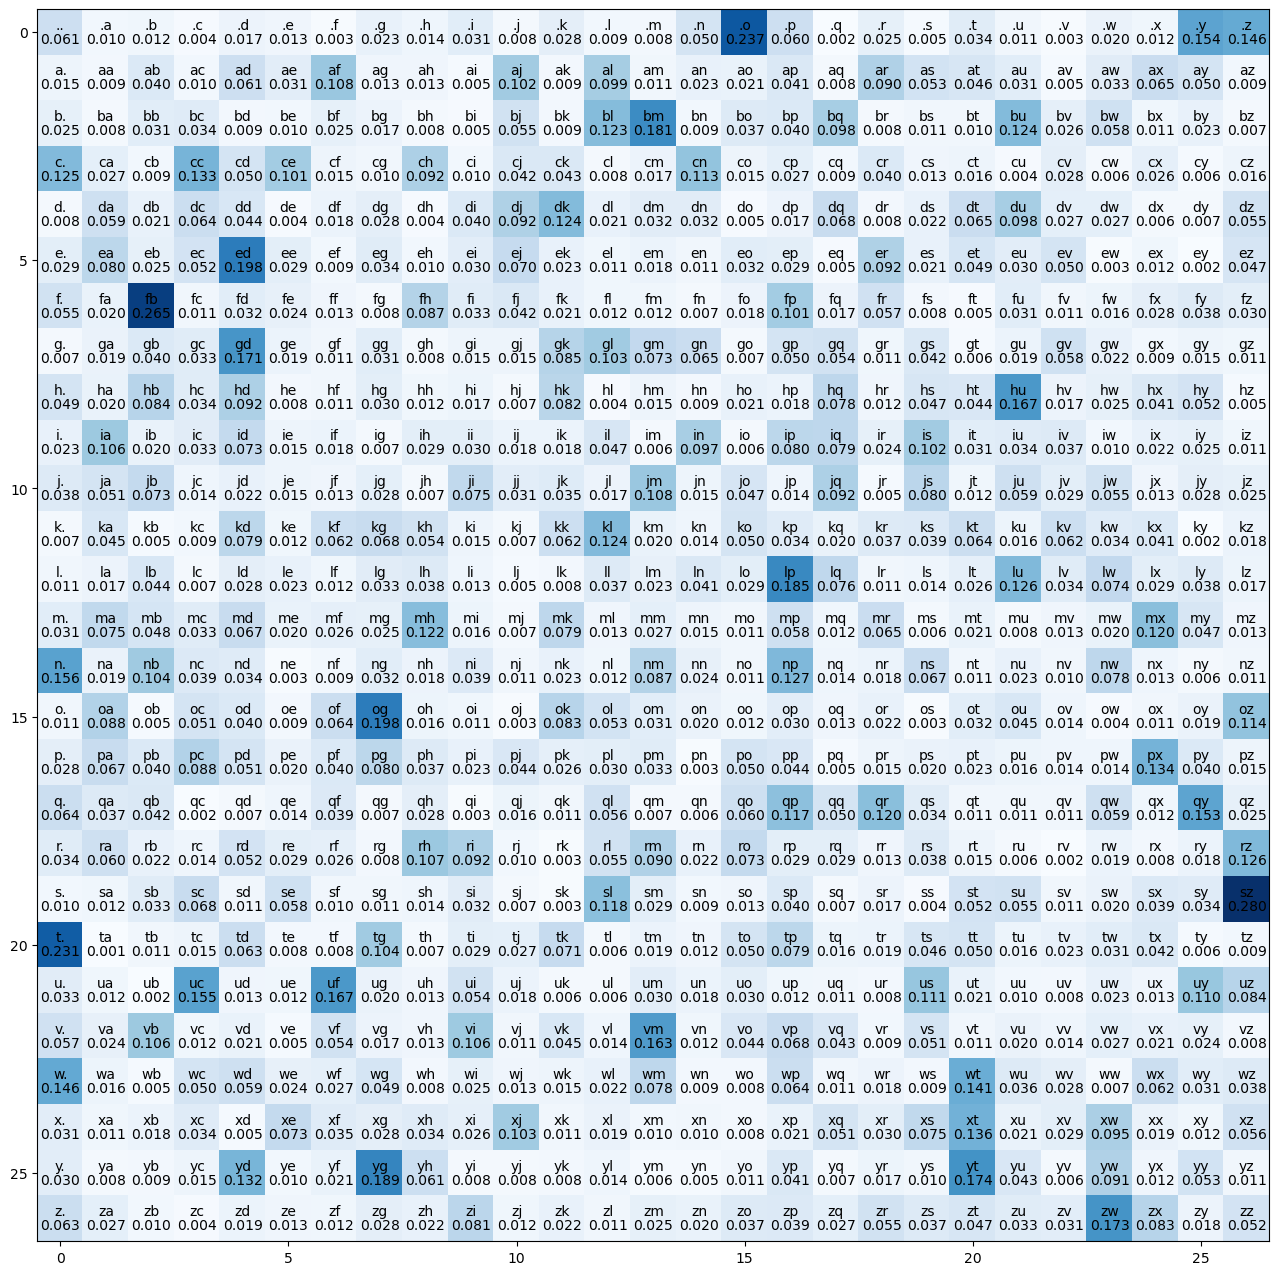

In [856]:
plt.figure(figsize = (16,16))
plt.imshow(prob.data, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %prob[i,j].item(), ha = "center", va = "top", color = "black")

We now want our training data to be the entire set of names rather than just Emma. We also want to run this process a lot of times inorder to get a small loss. Putting it all together and we have the three following blocks of code

In [857]:
xs, ys = [], [] 

for name in names:
    chs = ['.'] +list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

W = torch.randn((27,27), generator = g, requires_grad = True)

In [858]:
runs = 1000
for k in range(runs):
    counts = W.exp()
    prob = counts / counts.sum(1, keepdims = True)
    loss = -prob[xs, ys].log().mean() + 0.01* (W**2).mean()#the plus term is a bit of smoothing. 
    W.grad = None
    loss.backward()
    learning =  50 - 50*k/runs
    W.data -= learning *W.grad

print(loss)

tensor(2.4807, grad_fn=<AddBackward0>)


In [859]:
g = torch.Generator().manual_seed(2147483647)
counts = W.exp()
prob = counts / counts.sum(1, keepdims = True)
for i in range(10):
    ix = 0
    out = ''
    while True:
        ix = torch.multinomial(prob[ix], num_samples = 1, replacement = True, generator = g).item()
        
        if ix == 0:
            break
        out += itos[ix]

    print(out)

cexze
momasurailezityha
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


Recall, our initial list of names (if you kept the generator g) is as follows:
>1. cexze
2. momasurailezitynn
3. konimittain
4. llayn
5. ka
6. da
7. staiyaubrtthrigotai
8. moliellavo
9. ke
10. teda

Of the names produced, we produced 9 of them to be exactly the same. The other one only has a minor change at the end of the word. We observe the final set of probabilities. We encorage the reader to compare them to the probabilities calculated manually at the begining. It is reprinted directly below the matrix of the current probabilities for the readers convinence. 

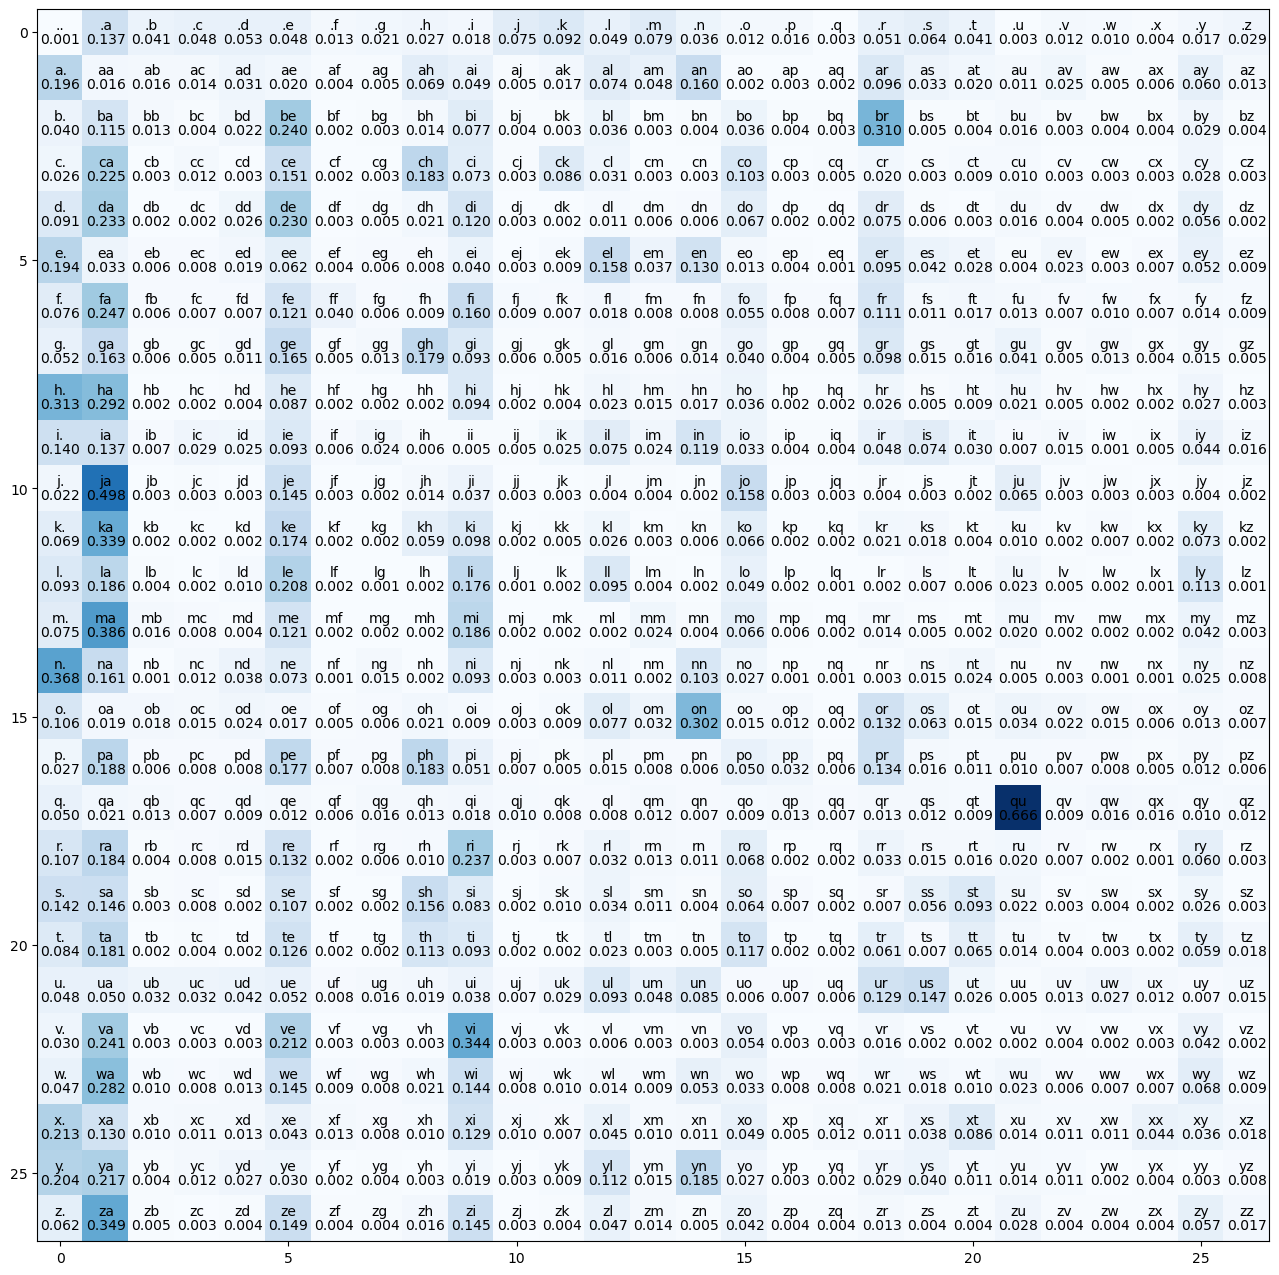

In [860]:
plt.figure(figsize = (16,16))
plt.imshow(prob.data, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %prob[i,j].item(), ha = "center", va = "top", color = "black")

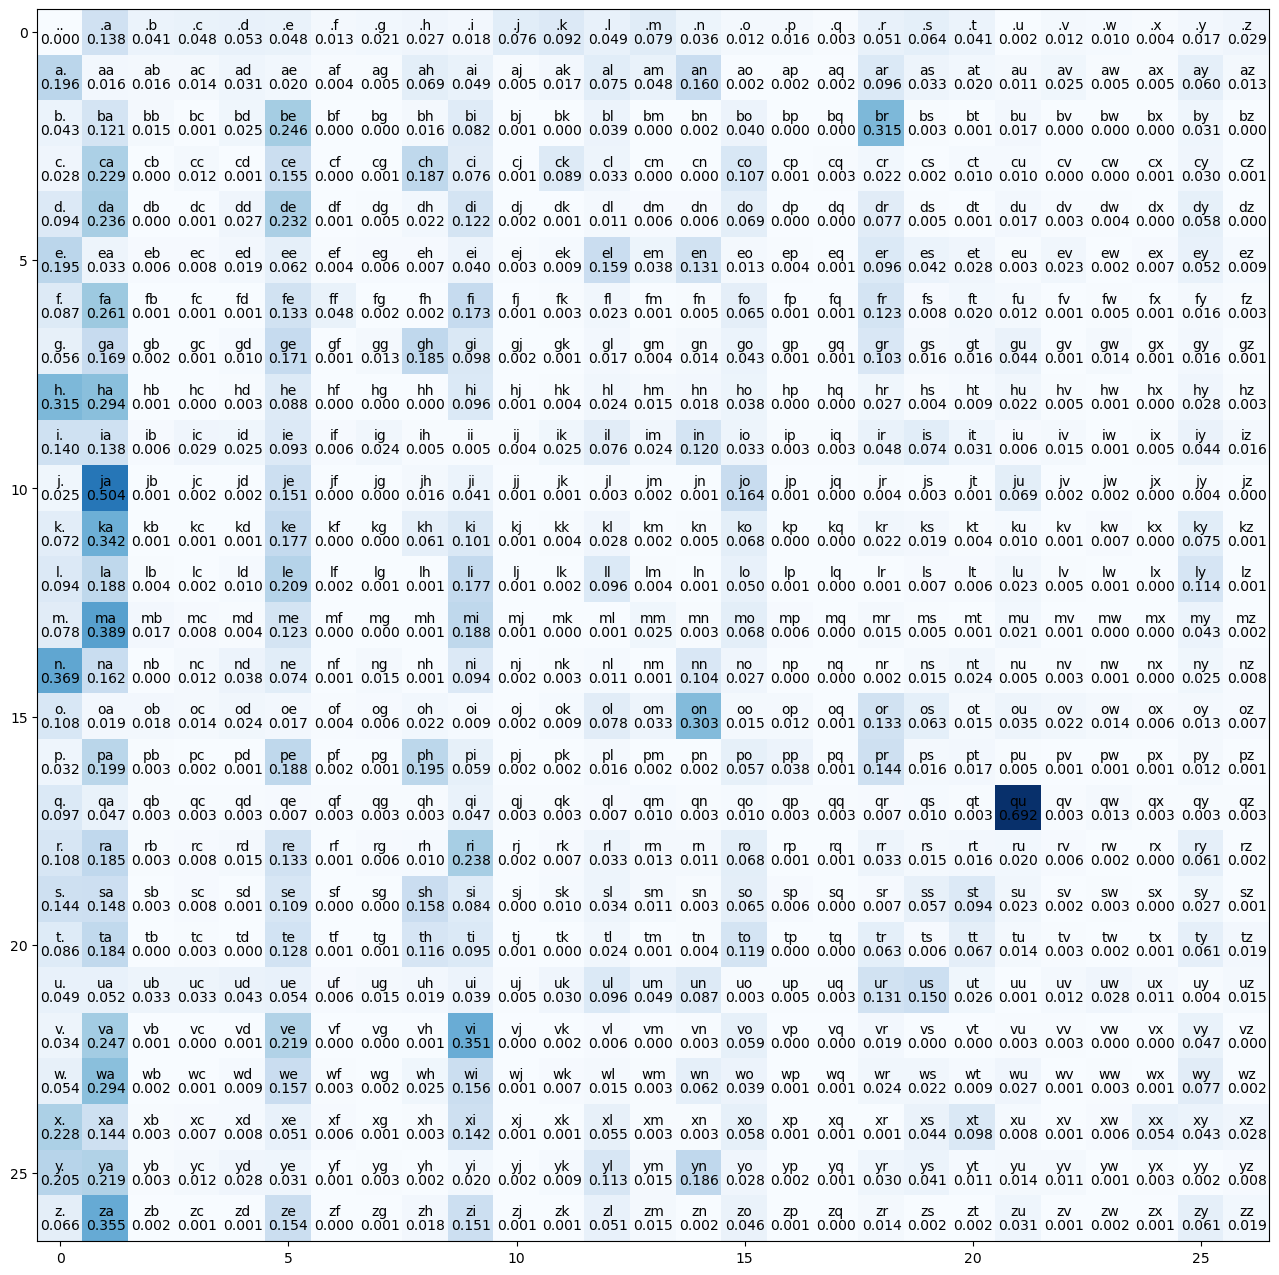

In [861]:
plt.figure(figsize = (16,16))
plt.imshow(P, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = "center", va = "bottom", color = "black")
        plt.text(j,i, '%.3f' %P[i,j].item(), ha = "center", va = "top", color = "black")

While not every probability is exactly the same, there is still a startaling resemblance for one of these being initially produced randomly. The next document will be go about how to improve this model even still now that we have incorperated a neural network learning model. The rest of this document will be an attempt to impliment the same basics of a learning model, but with a trigram model instead. We will use the previous two characters in order to predict the next character. This in theory should provide better name predictions. We recommend trying to read through this without documentation and try to understand what is going on. 

In [862]:
names = open('names.txt','r').read().splitlines()

In [863]:
freq_count = {}
for n in names:
    chs = ['.'] + ['.'] + list(n) + ['.'] + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        trigram = (ch1, ch2, ch3)
        freq_count[trigram] = freq_count.get(trigram, 0) + 1

In [864]:
sorted(freq_count.items(), key = lambda kv: -kv[1])

[(('n', '.', '.'), 6763),
 (('a', '.', '.'), 6640),
 (('.', '.', 'a'), 4410),
 (('e', '.', '.'), 3983),
 (('.', '.', 'k'), 2963),
 (('.', '.', 'm'), 2538),
 (('i', '.', '.'), 2489),
 (('.', '.', 'j'), 2422),
 (('h', '.', '.'), 2409),
 (('.', '.', 's'), 2055),
 (('y', '.', '.'), 2007),
 (('a', 'h', '.'), 1714),
 (('.', '.', 'd'), 1690),
 (('n', 'a', '.'), 1673),
 (('.', '.', 'r'), 1639),
 (('.', '.', 'l'), 1572),
 (('.', '.', 'c'), 1542),
 (('.', '.', 'e'), 1531),
 (('a', 'n', '.'), 1509),
 (('o', 'n', '.'), 1503),
 (('.', 'm', 'a'), 1453),
 (('r', '.', '.'), 1377),
 (('l', '.', '.'), 1314),
 (('.', '.', 't'), 1308),
 (('.', '.', 'b'), 1306),
 (('.', 'j', 'a'), 1255),
 (('.', 'k', 'a'), 1254),
 (('e', 'n', '.'), 1217),
 (('s', '.', '.'), 1169),
 (('.', '.', 'n'), 1146),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '.'), 953),
 (('a', 'r', 'i'), 950),
 (('.', '.', 'z'), 929),
 (('i', 'a', '.'), 903),
 (('.', '.', 'h'), 874),
 (('i', 'e', '.'), 858),
 (('o', '.', '.'), 855),
 (('a', 'n', 'n'), 8

In [865]:
N = torch.zeros((27,27,27), dtype = torch.int32)

In [866]:
chars = sorted(list(set(''.join(names)))) #creates a list of all letters in order (pretty sure there is a built in function for this but w.e)
stoi = {s:i+1 for i,s in enumerate(chars)} #creates a function that takes a letter and gives an integer
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} #creates a function that takes an integer and gives a letter

In [867]:
for n in names:
    chs = ['.'] + ['.'] + list(n) + ['.'] + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:],chs[2:]):
        i = stoi[ch1]
        j = stoi[ch2]
        k = stoi[ch3]
        N[i,j,k]+=1

In [868]:
N

tensor([[[   0, 4410, 1306,  ...,  134,  535,  929],
         [   0,  207,  190,  ...,   27,  173,  152],
         [   0,  169,    0,  ...,    0,    4,    0],
         ...,
         [   0,   57,    0,  ...,    1,   17,   11],
         [   0,  246,    0,  ...,    0,    0,    2],
         [   0,  456,    0,  ...,    0,   91,    1]],

        [[6640,    0,    0,  ...,    0,    0,    0],
         [  40,    0,    5,  ...,    0,   20,   11],
         [  36,   28,   20,  ...,    0,   12,    0],
         ...,
         [  11,    5,    0,  ...,   17,    6,    3],
         [ 163,  389,   13,  ...,    0,   16,   40],
         [  38,  123,    0,  ...,    0,   12,   22]],

        [[ 114,    0,    0,  ...,    0,    0,    0],
         [  46,    5,    5,  ...,    4,   31,    4],
         [   1,    8,    0,  ...,    0,    9,    0],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [  55,    4,    1,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

In [869]:
N[0,0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [870]:
P = (N+1).float()
P /= P.sum(2, keepdim = True)

In [871]:
g = torch.Generator().manual_seed(214748364214)

for i in range(10):
    newname = ''
    ix1 = 0 #start our name with '.'
    ix2 = 0
    while True:
        ix1, ix2 = ix2, torch.multinomial(P[ix1,ix2], num_samples = 1, replacement = True, generator = g).item() #select the appropriate row, and choose a new letter based on proabilites
        if ix2 ==0: #if the new letter selected is '.', we finish the name
            break
        newname += itos[ix2] #add the new letter to the name we are producing
    print(newname) #print the final name

cilynt
nae
sius
utorina
aubluo
zurshaaymin
anaylrosler
bayloudrione
ara
rey


In [872]:
loglikelihood = 0.00
n =0 
for name in names:
    chs = ['.'] + ['.'] + list(name) + ['.'] + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1,ix2, ix3]
        logprob = torch.log(prob)
        loglikelihood += logprob
        n+=1
        
nll = -loglikelihood
print(f'{nll=}')
print(f'{nll/n}')

nll=tensor(505260.7500)
1.9419735670089722


In [873]:
xs, ys = [], [] #initialize sets of inputs and outputs

for name in names[:1]:
    chs = ['.'] +['.'] +list(name) +['.'] +['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:],chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1, ix2)) #current letter is an input
        ys.append(ix3) #next letter is an output

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [874]:
xs

tensor([[ 0,  0],
        [ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1],
        [ 1,  0]])

In [875]:
ys

tensor([ 5, 13, 13,  1,  0,  0])

In [876]:
g = torch.Generator().manual_seed(214748364214)
W = torch.randn((27,27,27), generator = g, requires_grad = True)

In [877]:
counts = W.exp()
prob = counts/ counts.sum(2, keepdim = True)

In [878]:
nll = 0
j =0 
for i in range(6):
    nll-=prob[xs[i][0], xs[i][1]][ys[j]].log()
    j+=1
loss = nll/j

In [879]:
loss

tensor(3.5589, grad_fn=<DivBackward0>)

In [880]:
W.grad = None

In [881]:
loss.backward()

In [882]:
W.data -= .1*W.grad

In [883]:
counts = W.exp()
prob = counts/ counts.sum(2, keepdim = True)

In [884]:
nll = 0
j =0 
for i in range(6):
    nll-=prob[xs[i][0], xs[i][1]][ys[j]].log()
    j+=1
loss = nll/j

In [885]:
loss

tensor(3.5425, grad_fn=<DivBackward0>)

In [99]:
xs, ys, zs = [], [], []

for name in names:
    chs = ['.'] +['.'] +list(name) +['.']
    for ch1, ch2,ch3 in zip(chs, chs[1:],chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append(ix1)
        ys.append(ix2)
        zs.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
zs = torch.tensor(zs)
num = xs.nelement()

W = torch.randn((27,27,27), generator = g, requires_grad = True)
loss = None 

In [100]:
runs = 2000
for k in range(runs):
    counts = W.exp()
    prob = counts/ counts.sum(2, keepdim = True)
    loss = -prob[xs, ys, zs].log().mean()
    W.grad = None
    loss.backward()
    learning_rate = 200 - 200*k/runs
    W.data -= learning_rate * W.grad

print(loss)

tensor(2.2010, grad_fn=<NegBackward0>)


In [101]:
g = torch.Generator().manual_seed(214748364214)

counts = W.exp()
prob = counts/ counts.sum(2, keepdim = True)

for i in range(40):
    ix1 = 0
    ix2 = 0
    newname = ''
    while True:
        ix1, ix2 = ix2, torch.multinomial(prob[ix1,ix2], num_samples = 1, replacement = True, generator = g).item() #select the appropriate row, and choose a new letter based on proabilites
        if ix2 == 0: #if the new letter selected is '.', we finish the name
            break
        newname += itos[ix2] #add the new letter to the name we are producing

    print(newname)

cilynt
nae
sius
utorina
aublao
zurshaaymin
anayla
paer
bayloudrione
ara
rey
samen
aolesliah
ren
vitaubrpe
jakeni
blang
camsitddi
ce
hanie
pivalanda
joy
an
math
alislan
evinassio
tharne
jettim
melynna
damon
vleybadhyahlymer
ja
laudritana
oc
dyn
pri
lohniy
marlianatae
si
anna
